In [1]:
%matplotlib inline
import glob
import importlib
import uproot
import awkward
import numpy as np
import uproot_methods
import matplotlib.pyplot as plt
import concurrent.futures
import functools
import time
import pandas as pd
from tqdm.auto import tqdm

import utils
import manager
import plotting

importlib.reload(plotting);
importlib.reload(manager);
importlib.reload(utils);

# plotting.bokeh_output_notebook()

In [2]:
m = manager.Manager()
m

<Manager: broker='redis://uaf-1.t2.ucsd.edu:50185', workers=10>

In [3]:
%%time
def f(x):
    return x**2
m.local_map(f,range(10),progress_bar=False)

CPU times: user 4 ms, sys: 3 ms, total: 7 ms
Wall time: 5.02 ms


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [4]:
%%time
def f(x):
    return x**2
m.remote_map(f,range(10),return_metadata=False,progress_bar=False,skip_payload_check=True)

CPU times: user 9 ms, sys: 3 ms, total: 12 ms
Wall time: 16.2 ms


[9, 81, 4, 1, 25, 64, 49, 0, 36, 16]

In [5]:
fnames = glob.glob("/hadoop/cms/store/group/snt/nanoaod/DoubleMuon__Run201*-Nano1June2019*/*.root")
def f(fname):
    return uproot.open(fname)["Events"].array("MET_pt").mean()
results = m.remote_map(f,fnames[:30],return_metadata=True)

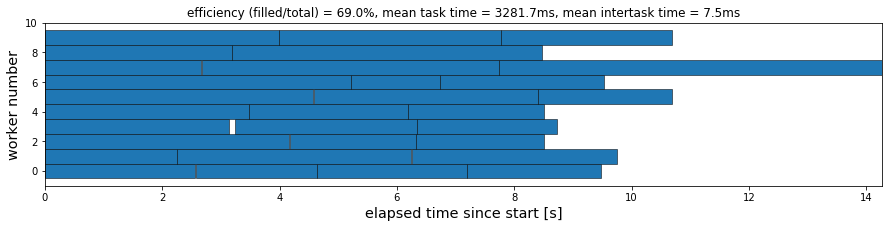

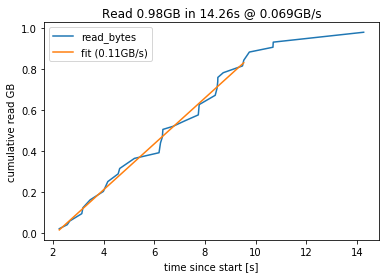

In [6]:
# plotting.plot_timeflow_bokeh(results)
plotting.plot_timeflow(results)
plotting.plot_cumulative_read(results)

In [7]:
%%time
fnames = sorted(glob.glob("/hadoop/cms/store/group/snt/nanoaod/DoubleMuon__Run*/*.root"))[:50]

chunks, total_nevents = utils.get_chunking(tuple(fnames),int(1.0e6))
print("{} chunks of {} files, with a total of {:.5g} events".format(len(chunks),len(fnames),total_nevents))

113 chunks of 50 files, with a total of 8.9124e+07 events
CPU times: user 7 s, sys: 412 ms, total: 7.41 s
Wall time: 1.68 s


In [8]:
def get_mll_hist(args):
    fname,entrystart,entrystop = args
    """
    return 
    - event count considered
    - array of histogram bin counts for m(mumu) for nmu==2 events
    """
    try:
        worker = get_worker()
        cache = worker.cache
    except:
        cache = None
    f = uproot.open(fname)
    t = f["Events"]
    extra = dict(outputtype=tuple,namedecode="ascii",entrystart=entrystart,entrystop=entrystop,cache=cache)
    p4 = uproot_methods.TLorentzVectorArray.from_ptetaphim(
        *t.arrays(["Muon_pt","Muon_eta","Muon_phi","Muon_mass"],**extra)
    )
    charge,mediumid,reliso = t.arrays(["Muon_charge","Muon_mediumId","Muon_pfRelIso04_all"],**extra)
    mus = awkward.JaggedArray.zip(p4=p4,charge=charge,mediumid=mediumid,reliso=reliso)
    nevents = len(mus)
    # retain MUONS passing ID/iso and min pt
    mus = mus[mus.mediumid & (mus.reliso < 0.35) & (mus.p4.pt>=7)]
    # retain EVENTS with 2 muons
    mus = mus[mus.counts==2]
    # retain EVENTS with muons of pt>15 chargesum=0
    mus = mus[(mus[:,0].p4.pt>15.) & (mus[:,1].p4.pt>15.) & (mus[:,:2].charge.sum()==0)]
    mll = (mus[:,0]+mus[:,1]).p4.mass
    bins = np.linspace(50,400,100)
    counts,_ = np.histogram(np.clip(mll,bins[0],bins[-1]),bins=bins)
    return counts

# run the function locally first, so if it crashes, we know not to submit them remotely
get_mll_hist(chunks[0]);

In [9]:
%%time
results = m.remote_map(get_mll_hist,chunks,reuse_chunking=True,return_metadata=True)


CPU times: user 675 ms, sys: 58 ms, total: 733 ms
Wall time: 2min 8s


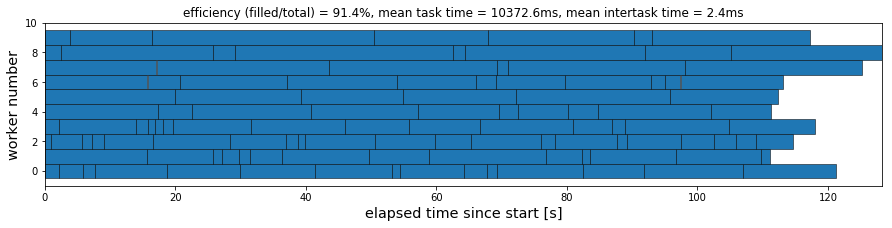

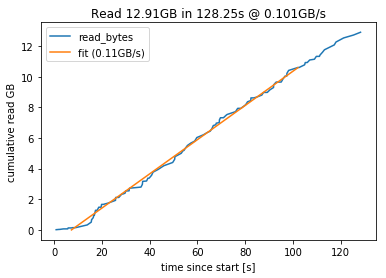

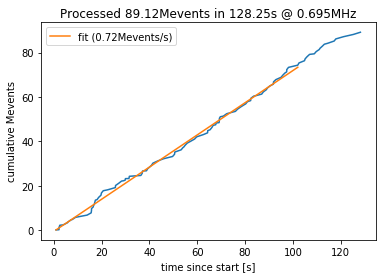

In [10]:
plotting.plot_timeflow(results)
plotting.plot_cumulative_read(results)
plotting.plot_cumulative_events(results)

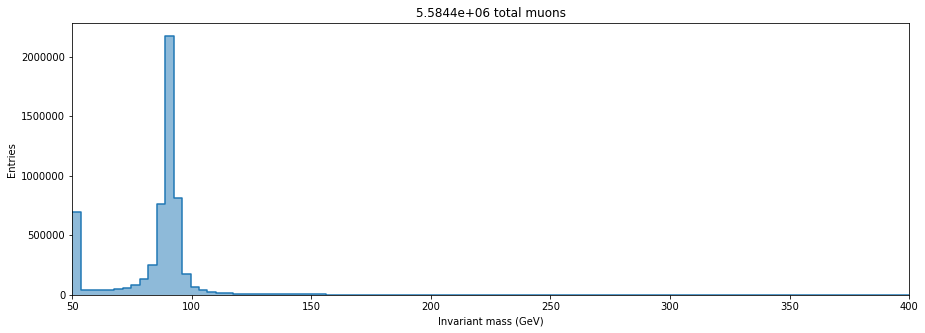

In [11]:
bins = np.linspace(50,400,100)
counts = sum(r["result"] for r in results)
fig,ax = plt.subplots(figsize=(15,5))
ax.step(x=bins, y=np.append(counts,0), where="post")
ax.fill_between(x=bins, y1=np.append(counts,0), step="post",alpha=0.5)
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel("Invariant mass (GeV)")
ax.set_title("{:.5g} total muons".format(counts.sum()))
ax.set_ylabel("Entries");

In [12]:
%%time
results = m.remote_map(get_mll_hist,chunks,reuse_chunking=True,return_metadata=True)

Current chunking matches old chunking, so we will re-use the old worker ordering to make use of caching



CPU times: user 554 ms, sys: 90 ms, total: 644 ms
Wall time: 35.7 s


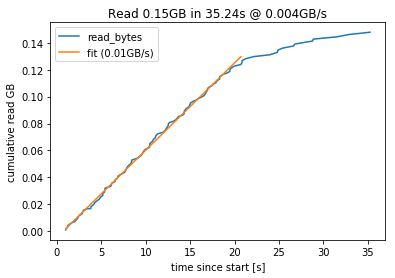

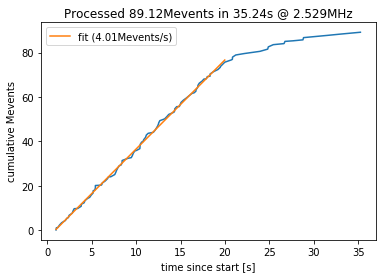

In [13]:
plotting.plot_timeflow_bokeh(results)
plotting.plot_cumulative_read(results)
plotting.plot_cumulative_events(results)